
# Convolutional Neural Network on the MNIST Dataset
This is a notebook that builds and trains a simple CNN on the ever so popular [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The MNIST dataset is a large collection of handwritten digits like this sample of the number 8. 

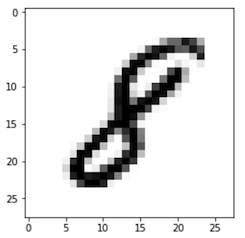

Our mission - we have no choice but to accept it - is to fit a basic CNN on the data and get a good testing accuracy.

We start off by **importing the necessary libraries**

**Formatting Data**

Next, we're going to format our data. Data formatting is a tedious but crucial part of deep learning. It is necessary to format your inputs in a way that will be easy to understand for the model you are trying to train. We have formatted the data for you but in the future, you will have to pay close attention to what the dataset contains and what your model actually needs.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from EntropySGD import EntropySGD
import matplotlib.pyplot as plt

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

cuda:0


In [5]:


batch_size = 128

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Designing Our Model**

Next, lets design our CNN. We use Sequential from Keras to help design our model. The Sequential type of a model lets us add layers one by one in a linear fashion. Our first layer has to be our input layer.

In [124]:

# 2. Define a Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

import torch as T
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # pre Python 3.3 syntax

        self.conv1 = T.nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
        self.conv2 = T.nn.Conv2d(32, 64, 5)
        self.fc1 = T.nn.Linear(1024, 512)   # [64*4*4, x]
        self.fc2 = T.nn.Linear(512, 256)
        self.fc3 = T.nn.Linear(256, 10)     # 10 classes
        self.pool1 = T.nn.MaxPool2d(2, stride=2)
        self.pool2 = T.nn.MaxPool2d(2, stride=2)
        self.drop1 = T.nn.Dropout(0.25)
        self.drop2 = T.nn.Dropout(0.50)

    def forward(self, x):
        # convolution phase         # x is [bs, 1, 28, 28]
        z = T.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
        z = self.pool1(z)           # Size([bs, 32, 12, 12])
        z = self.drop1(z)
        z = T.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
        z = self.pool2(z)           # Size([bs, 64, 4, 4])

        # neural network phase
        z = z.reshape(-1, 1024)     # Size([bs, 1024])
        z = T.relu(self.fc1(z))     # Size([bs, 512])
        z = self.drop2(z)
        z = T.relu(self.fc2(z))     # Size([bs, 256])
        z = self.fc3(z)             # Size([bs, 10])
        return z


In [125]:
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss


criterion = nn.CrossEntropyLoss()

We have now designed our model by putting in all the layers. We haven't yet compiled our model with an optimizer or a loss function.

In [126]:
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.


def eval():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

L=20


In [127]:
epochs=10
loss_sgd=[]
loss_entropy_sgd=[]

errors_sgd=[]
errors_entropy_sgd=[]

accuracy_sgd=[]
accuracy_entropy_sgd=[]




In [128]:
print("Running Entropy-SGD optimizer")
net_entropy = Net()
net_entropy.to(device)

optimizer = EntropySGD(net_entropy.parameters(), momentum=0.9, nesterov=True)

for epoch in range(epochs):  # loop over the dataset multiple times
    dataiter = iter(trainloader)
    accuracy=0
    total=0
    running_loss=0
    def closure():
        data = dataiter.next()
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net_entropy(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        global accuracy, total, running_loss
        accuracy+=(torch.argmax(outputs, dim=1)==labels).cpu().detach().numpy().sum()
        total+=labels.size()[0]
        running_loss += loss.item()/labels.size()[0]
        return loss


    for step in range(len(dataiter)//L):
        optimizer.step(closure)
    print('[%d, %.3f] loss: %.3f' %
          (epoch + 1, accuracy/total , running_loss ))
    loss_entropy_sgd.append(running_loss)
    accuracy_entropy_sgd.append(accuracy/total)
    err = 1-eval()
    errors_entropy_sgd.append(err)

    print("epoch done", epoch+1)
print('Finished Training')

Running Entropy-SGD optimizer
[1, 0.858] loss: 1.715
epoch done 1
[2, 0.975] loss: 0.315
epoch done 2
[3, 0.982] loss: 0.223
epoch done 3
[4, 0.985] loss: 0.179
epoch done 4
[5, 0.987] loss: 0.150
epoch done 5
[6, 0.988] loss: 0.145
epoch done 6
[7, 0.989] loss: 0.129
epoch done 7
[8, 0.990] loss: 0.115
epoch done 8
[9, 0.991] loss: 0.108
epoch done 9
[10, 0.992] loss: 0.096
epoch done 10
Finished Training


In [114]:
print("Running SGD optimizer")
net_sgd = Net()
net_sgd.to(device)

optimizer = torch.optim.SGD(net_sgd.parameters(), lr=0.001, momentum=0.9, nesterov=True)

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    accuracy=0
    total=0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_sgd(inputs)
        loss = criterion(outputs, labels)
        accuracy+=(torch.argmax(outputs, dim=1)==labels).cpu().detach().numpy().sum()
        total+=labels.size()[0]
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print('[%d, %.3f] loss: %.3f' %
          (epoch + 1, accuracy/total , running_loss / i))

    err = 1 - eval()
    errors_sgd.append(err)
    loss_sgd.append(running_loss)
    accuracy_sgd.append(accuracy/total)

    print("epoch done", epoch+1)
print('Finished Training')

Running SGD optimizer
[1, 0.536] loss: 1.533
epoch done 1
[2, 0.889] loss: 0.371
epoch done 2
[3, 0.929] loss: 0.235
epoch done 3
[4, 0.946] loss: 0.177
epoch done 4
[5, 0.955] loss: 0.147
epoch done 5
[6, 0.962] loss: 0.125
epoch done 6
[7, 0.965] loss: 0.113
epoch done 7
[8, 0.969] loss: 0.103
epoch done 8
[9, 0.971] loss: 0.095
epoch done 9
[10, 0.973] loss: 0.088
epoch done 10
Finished Training


errors: [0.14280000000000004, 0.07909999999999995, 0.05720000000000003, 0.04279999999999995, 0.0383, 0.034399999999999986, 0.03290000000000004, 0.02969999999999995, 0.026100000000000012, 0.024599999999999955]


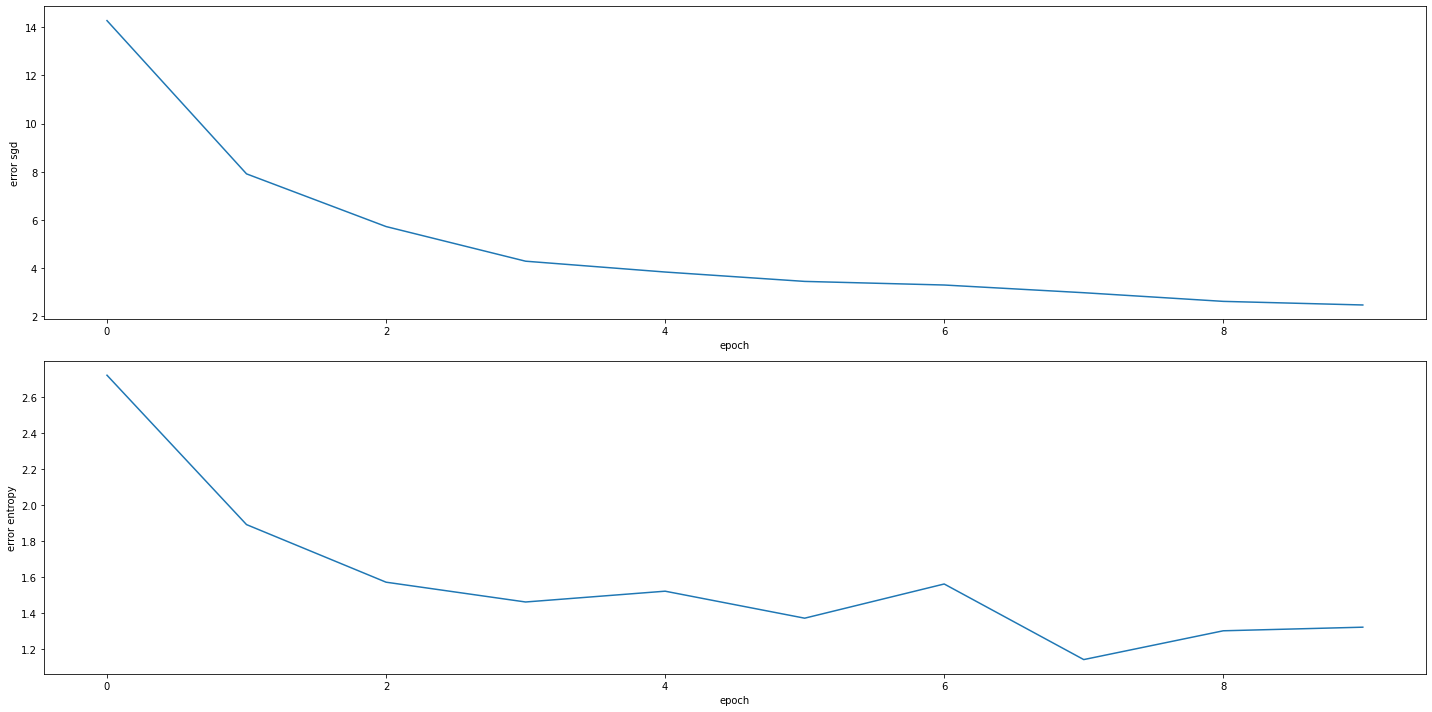

In [115]:

print("errors:", errors_sgd)
fig,axs=plt.subplots(2,figsize=(20,10))

axs[0].plot([err*100 for err in errors_sgd])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('error sgd')

axs[1].plot([err*100 for err in errors_entropy_sgd])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('error entropy')

fig.tight_layout()
fig.show()



In [118]:

# what are the classes that performed well, and the classes that did
# not perform well:
# with torch.no_grad():
#         for data in testloader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = net(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of     0 : 100 %
Accuracy of     1 : 96 %
Accuracy of     2 : 97 %
Accuracy of     3 : 100 %
Accuracy of     4 : 97 %
Accuracy of     5 : 95 %
Accuracy of     6 : 96 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
